# Project Natural Language Processing (NLP)

## Goal:
Develop a predictive model to identify GitHub repository's primary programming language using README file content.

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
import acquire as a
import prepare as p
import lugo_explore as e
import modeling as m


# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# Acquire
- Data acquired from GitHub's <a href='https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories'>the most starred repositories</a>
- It contained 960 rows and 3 columns before cleaning
- Each row represents a repository from GitHub with a README.md file. 
- Each column contains information from the repository

In [2]:
# acquire data
df = a.get_readmes()

# Data Dictionary

| Feature         | Description                                                                             |
| --------------- | --------------------------------------------------------------------------------------- |
| repo            | The owners/organization and the repository name                                         |
| language        | The most common programming language in the repository                                  |
| top3other       | The top 3 most common programming languages across repositories and the rest are other  |
| readme_contents | The content inside the README.md file                                                   |
| clean           | The content after the prepare phase.                                                    |
| lemmatized      | The clean content after being lemmatized.                                               |

# Prepare
- Removed 379 duplicates
- Didn't rename the columns
- Checked for nulls and removed 37 rows
- Checked that column data types were appropriate for exploration
- Outliers were found but kept them as we felt they could be important
- Added a target column named "top3other"
- A new feature was created named "length"
- No encoded categorical variables
- Split data into train, validate, and test (60/20/20), stratifying is 'top3other'
- NO Scaler was performed
- Cleaned the readme content using normalize, tokenize, stopwords and lemmatize

In [3]:
# preparing data for exploration
df = p.prep_readmes(df)

## Splitting Data

In [4]:
# splitting data in to train, validate, and test
train, validate, test = p.split_data(df, 'top3other')

In [5]:
train.shape, validate.shape, test.shape

((326, 6), (109, 6), (109, 6))

In [6]:
train.head()

,repo,language,readme_contents,clean,lemmatized,top3other
407,hagsteel/swampdragon,JavaScript,# SwampDragon\n\n# Looking for someone to take...,swampdragon looking someone take longer time s...,swampdragon looking someone take longer time s...,JavaScript
414,doczjs/docz,TypeScript,"<p align=""left"">\n <a href=""https://www.npmjs...",p alignleft hrefhttps www npmjs com package do...,p alignleft hrefhttps www npmjs com package do...,other
109,autresphere/ASMediaFocusManager,Objective-C,## ASMediaFocusManager\nASMediaFocusManager gi...,asmediafocusmanager asmediafocusmanager gives ...,asmediafocusmanager asmediafocusmanager give a...,Objective-C
238,cmaddux/littlebox,CSS,"# littlebox\nSuper simple to use, CSS-only ico...",littlebox super simple use css icons littlebox...,littlebox super simple use cs icon littlebox h...,other
318,sstephenson/stitch,CoffeeScript,"<img src=""https://github.com/downloads/sstephe...",img srchttps github com downloads sstephenson ...,img srchttps github com downloads sstephenson ...,other


## A summary of the data

In [7]:
train.describe()

,repo,language,readme_contents,clean,lemmatized,top3other
count,326,326,326,326,326,326
unique,326,29,326,326,326,4
top,hagsteel/swampdragon,JavaScript,# SwampDragon\n\n# Looking for someone to take...,swampdragon looking someone take longer time s...,swampdragon looking someone take longer time s...,other
freq,1,90,1,1,1,138


## A brief look at the data

In [8]:
train.head()

,repo,language,readme_contents,clean,lemmatized,top3other
407,hagsteel/swampdragon,JavaScript,# SwampDragon\n\n# Looking for someone to take...,swampdragon looking someone take longer time s...,swampdragon looking someone take longer time s...,JavaScript
414,doczjs/docz,TypeScript,"<p align=""left"">\n <a href=""https://www.npmjs...",p alignleft hrefhttps www npmjs com package do...,p alignleft hrefhttps www npmjs com package do...,other
109,autresphere/ASMediaFocusManager,Objective-C,## ASMediaFocusManager\nASMediaFocusManager gi...,asmediafocusmanager asmediafocusmanager gives ...,asmediafocusmanager asmediafocusmanager give a...,Objective-C
238,cmaddux/littlebox,CSS,"# littlebox\nSuper simple to use, CSS-only ico...",littlebox super simple use css icons littlebox...,littlebox super simple use cs icon littlebox h...,other
318,sstephenson/stitch,CoffeeScript,"<img src=""https://github.com/downloads/sstephe...",img srchttps github com downloads sstephenson ...,img srchttps github com downloads sstephenson ...,other


# Explore

## Question 0: What is the distribution of the target?

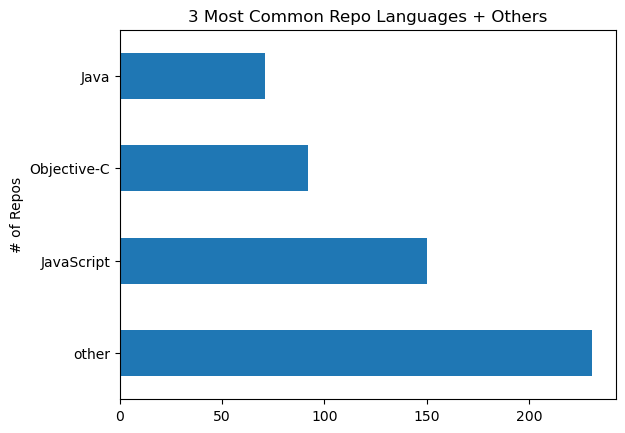

In [10]:
df.top3other.value_counts().plot(kind='barh',title='3 Most Common Repo Languages + Others',xlabel='# of Repos',ylabel='Most Common Language or Other');

## Question 0: What is the distribution of the Split?

In [11]:
df_value_counts = e.get_normalized_value_counts(train, validate, test)
df_value_counts

,train,val,test
other,0.423313,0.431193,0.422018
JavaScript,0.276074,0.275229,0.275229
Objective-C,0.168712,0.165138,0.174312
Java,0.131902,0.128440,0.128440


<div class="alert alert-block alert-info"> 
<b>Initial Explore Summarize</b>

- The top 5 most common words were JavaScript, Objective-C, Java, Ruby, and Swift. 
- This was not a Normal Distribution of our programming languages
- We split the programming language into 4 categories so we could have fewer uinque values to predict

</div>

## Question 1: What are the most common words in READMEs?

In [12]:
all_words = [word for row in df['lemmatized'] for word in row.split()]
len(all_words)

299471

In [13]:
all_freq = pd.Series(all_words).value_counts()
all_freq.head(20)

http       8045
com        6204
github     3831
use        1774
io         1425
j          1413
file       1287
org        1217
code       1135
license    1060
example    1051
www        1019
img         978
master      974
project     939
install     932
using       930
image       928
default     897
name        867
dtype: int64

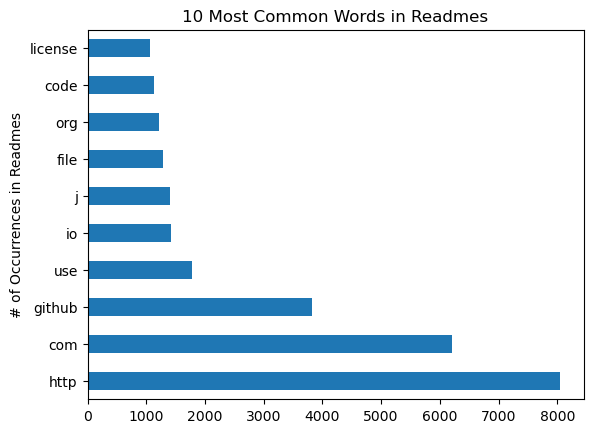

In [14]:
all_freq.head(10).plot(kind='barh',title='10 Most Common Words in Readmes',xlabel='# of Occurrences in Readmes',ylabel='Word');

<div class="alert alert-block alert-info"> 
<b>Question 1 Summarize</b>

- To our surprise we found the following words to be the top words in the README files. http: 8045, com: 6204, github: 3831, use: 1774, io: 1425
- "j" was originaly "js" and that's the reason it came in fourth place. 
</div>

## Question 2: Does the length of the README vary by programming language?

In [15]:
# looking at lemmatized column to stay consistent
# create column based on length of lemmatized readme
train = train.assign(length = train['lemmatized'].str.len())

In [16]:
train.groupby('top3other').length.mean()

top3other
Java           3350.209302
JavaScript     4707.155556
Objective-C    3747.290909
other          4270.210145
Name: length, dtype: float64

In [17]:
train.groupby('top3other').length.median()

top3other
Java           1830.0
JavaScript     2951.0
Objective-C    2155.0
other          2588.0
Name: length, dtype: float64

In [18]:
train.length.median()

2382.0

In [19]:
train[train.length<50000].groupby('top3other').length.mean()

top3other
Java           2130.071429
JavaScript     4707.155556
Objective-C    3747.290909
other          4270.210145
Name: length, dtype: float64

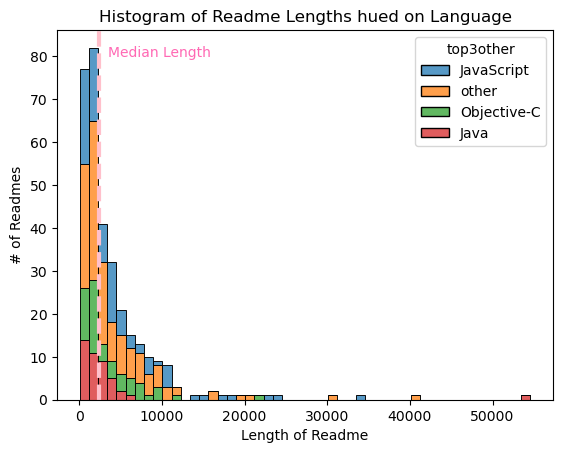

In [20]:
e.plot_readme_lengths(train)

### Analyze feature_x vs target with stats
- $H_0$: The readme lengths of one language are NOT significantly different than the population median readme length
- $H_a$: The readme lengths of one language are significantly different than the population median readme length
- $\alpha$ = .05
- Utilized the Wilcoxon signed-rank test: it compares two related samples to see if they come from the same distribution. It's a non-parametric alternative to the paired t-test, useful when normal distribution cannot be assumed.

In [21]:
# null hyp Javascript readme lengths are about the same as the population median readme lengths
e.wilcox(train,'top3other','JavaScript','length')

Wilcoxon Test:
 stat = 1327.0, p = 0.0037427048598427737


In [22]:
e.compare_readme_lengths(train, alpha=0.05)

|--------------------------------------|
JavaScript
The readme lengths of JavaScript are significantly different than the population median readme length (p=0.0037427048598427737).
|--------------------------------------|
other
The readme lengths of other are significantly different than the population median readme length (p=0.0066475281931874025).
|--------------------------------------|
Objective-C
The readme lengths of Objective-C are NOT significantly different than the population median readme length (p=0.09797105343358414).
|--------------------------------------|
Java
The readme lengths of Java are NOT significantly different than the population median readme length (p=0.25668872674623344).


<div class="alert alert-block alert-info"> 
<b>Question 2 Summarize</b>

- p is < $\alpha$ in JavaScript and other languages, so we rejected the $H_0$ which suggest the $H_a$ the readme lengths of one language are significantly different than the population median readme length

</div>

## Question 3: Do different programming languages use a different number of unique words?

In [23]:
javascript, java, objective_c, other, all_words = e.count_unique_words_by_language(train)

JavaScript unique words: 7580
Java unique words: 4232
Objective-C unique words: 4521
Other unique words: 10504
All unique words: 19470


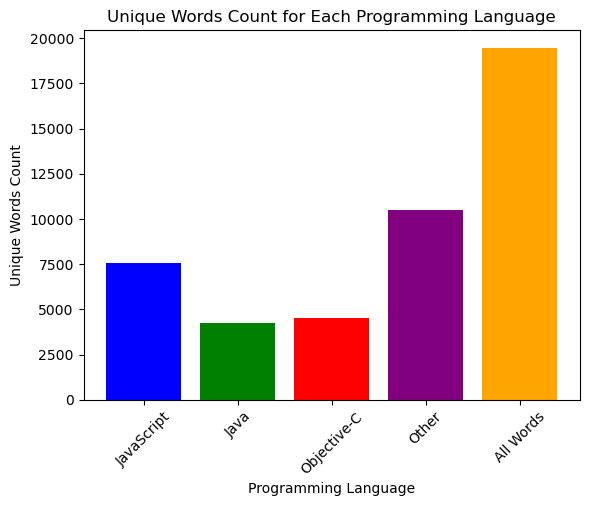

In [24]:
e.plot_unique_words_count(javascript, java, objective_c, other, all_words)

<div class="alert alert-block alert-info"> 
<b>Question 3 Summarize</b>

- These results suggest that the vocabulary used in README files can vary significantly depending on the programming language. The "other" category and JavaScript projects tend to use a wider range of vocabulary, while Java projects use a more limited set of words. This could be due to a variety of factors, including the complexity of the projects, the conventions of the programming language community, or the personal style of the authors.

</div>

## Question 4: Are there any words that uniquely identify a programming language?

In [25]:
unique_word_dicts = e.analyze_unique_words(javascript, java, objective_c, other)
uni_javascript = unique_word_dicts[0]
uni_java = unique_word_dicts[1]
uni_objective_c = unique_word_dicts[2]
uni_other = unique_word_dicts[3]

In [26]:
df = e.conv_dict_to_df(unique_word_dicts)
df.sort_values(by='uni_javascript', ascending=False).head(20)

,uni_javascript,uni_java,uni_objective_c,uni_other
j,651.0,NaN,NaN,NaN
td,615.0,NaN,NaN,NaN
www,375.0,96.0,NaN,NaN
code,352.0,69.0,NaN,NaN
react,318.0,NaN,NaN,NaN
use,300.0,NaN,171.0,525.0
function,300.0,NaN,NaN,NaN
npm,291.0,NaN,NaN,NaN
element,284.0,NaN,NaN,NaN
p,264.0,NaN,NaN,NaN


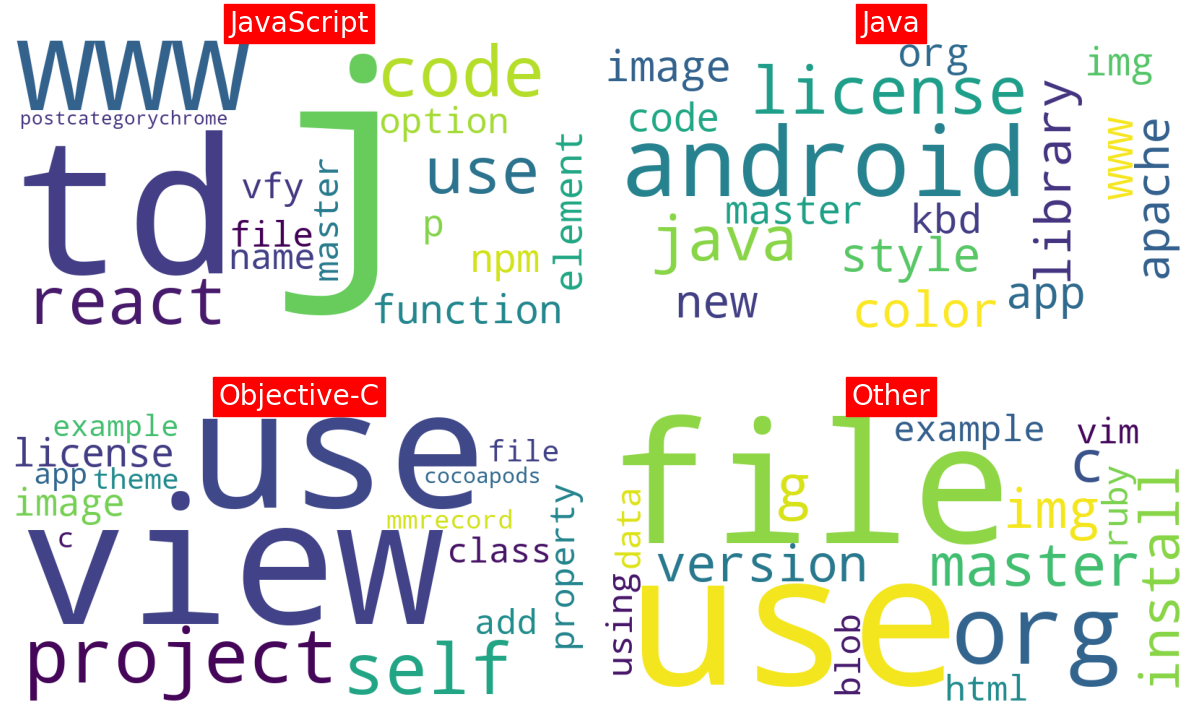

In [27]:
e.create_word_clouds(uni_javascript, uni_java, uni_objective_c, uni_other)

<div class="alert alert-block alert-info"> 
<b>Question 4 Summarize</b>

- The results indicate that there are unique words in each of the language that we tested. The unique words and their frequencies in each language, represented as dictionaries and visualized in the word clouds. This give insights into this. If there are words that appear frequently in one language and not in others, these words could potentially be used to identify that language. 
    
- NOTE: Not all words identify as unique may not necessarly be able to identify the programmig languages in other dataset. 

</div>

## Exploration Summary

* The initial exploration revealed the top three common languages: JavaScript, Objective-C, and Java. Surprising findings emerged in Question 1, with "http," "com," "github," "use," and "io" being the most frequent words in README files. Question 2's hypothesis test showed significant differences in readme lengths across some programming languages. Question 3 highlighted variations in vocabulary, with wider ranges in the "other" and JavaScript projects and more limited usage in Java. Question 4 identified unique words specific to each language, potentially aiding language identification. Overall, this analysis deepened our understanding of programming languages and their characteristics in README files.

<div class="alert alert-block alert-success"> 
<b>Features moving to modeling</b>

- All lemmatized words were used!
- Unique lemmatized words for each language
- Unique lemmatized words, bigrams, and trigrams for each language
* feature: length was only used during exploration for question 2.

</div>

# Modeling
* Evaluation Most Comment = "other" that gives us a 0.4233128834355828 which is the baseline prediction 
* I will evaluate 3 different model types and various hyperparameter configurations
    * Complement Naive Bayes, Multinomial Naive Bayes, Logistic Regression Model
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test

In [28]:
feat = m.get_unique(train)

JavaScript unique words: 7580
Java unique words: 4232
Objective-C unique words: 4521
Other unique words: 10504
All unique words: 19470


In [29]:
X_train, X_val, X_test, y_train, y_val, y_test = m.get_Xs(train, validate, test)
Xtr_tfidf,Xv_tfidf,Xt_tfidf = m.make_tfidf(X_train,X_val,X_test)
Xtr_cv,Xv_cv,Xt_cv = m.make_cv(X_train,X_val,X_test)

In [30]:
feature = m.get_unique2(train)
features = [col for col in list(set(feature)) if col in Xtr_cv.columns]

### BASELINE

In [31]:
# baseline
y_train.value_counts(normalize=True)[0]

0.4233128834355828

## Complement Naive Bayes Model

In [32]:
# Complement Naive Bayes
m.cnb_model(Xtr_tfidf[features],y_train,Xv_tfidf[features],y_val)

Complement Naive Bayes
Train Accuracy:      100.0%
Validation Accuracy: 80.73%


<div class="alert alert-block alert-info"> 
<b>Complement Naive Bayes Model Summarize</b>

- The Complement Naive Bayes model significantly outperforms the baseline, achieving a training accuracy of 80.73% and a validation accuracy of 78.9%.

</div>

## Multinomial Naive Bayes Model

In [33]:
# Multinomial Naive Bayes
m.mnb_model2(Xtr_cv[features],y_train,Xv_cv[features],y_val)

Multinomial Naive Bayes
Train Accuracy:      100.0%
Validation Accuracy: 78.9%


<div class="alert alert-block alert-info"> 
<b>Multinomial Naive Bayes Model Summarize</b>

- The Multinomial Naive Bayes model also achieved a high training accuracy of 100.0% and validation accuracy of 78.6%.

</div>

## Logistic Regression Model

In [34]:
# Logistic Regression
m.log_model(Xtr_tfidf[feat],y_train,Xv_tfidf[feat],y_val)

Logistic Regression
Train Accuracy:      97.55%
Validation Accuracy: 77.06%


<div class="alert alert-block alert-info"> 
<b>Logistic Regression Model Summarize</b>

- The Logistic Regression model achieves a training accuracy of 97.55% and a slightly lower validation accuracy of 77.06% compared to the Naive Bayes models.

</div>

## Comparing Models
* All three models significantly outperform the baseline. The Complement model achieve the highest validate accuracy of 80.73%, while the Logistic Regression and Multinomial Naive Bayes model, had a slightly lower validation accuracy.

## Test on Best Model: Complement Naive Bayes

In [35]:
# tested on the CNB
m.test_model(Xtr_tfidf[features],y_train,Xt_tfidf[features],y_test)

Complement Naive Bayes
Baseline Accuracy: 42.33%
Test Accuracy:     69.72%


<div class="alert alert-block alert-info"> 
<b>Test Summarize</b>

- The Complement Naive Bayes model was tested on unseen data and achieved a test accuracy of 69.72%, which is significantly higher than the baseline accuracy of 42.33%. This suggests that the model generalizes well and is effective at predicting the programming language from README files.

</div>

<div class="alert alert-block alert-success"> 
<b>Modeling Summary</b>

* Three models - Complement Naive Bayes, Multinomial Naive Bayes, and Logistic Regression - were trained to predict a GitHub repository's programming language from its README file. All models significantly outperformed the baseline, with the Complement Naive Bayes model achieving the highest validation accuracy of 80.73%. The Multinomial Naive Bayes and Logistic Regression model, while slightly less accurate, may offer better interpretability. In testing, the Complement Naive Bayes model demonstrated good generalization to unseen data, achieving a test accuracy of 69.72%, significantly higher than the baseline. These results suggest that these models, particularly the Complement Naive Bayes model, is effective at predicting a repository's programming language from its README file. 

</div>

# Conclusions

## Exploration
* bullets

## Modeling
* bullets

## Recommendations
* bullets

## Next steps
* bullets